# Landsat-8


<div class="alert-info">

### Overview
    
* **teaching:** 30 minutes
* **exercises:** 0
* **questions:**
    * How can I find, anaylize, and visualize Landsat8 satellite imagery for an area of interest using Python?
    
</div>


This notebook will focus on accessing public datasets on AWS for a target area affected by Cyclone Kenneth (2019-04-25). Read more about this event and its impact at the [Humanitarian Open Street Map website](https://tasks.hotosm.org/project/5977). We will use a bounding box we will work with covers the island of Nagazidja, including the captial [city of Moroni](https://en.wikipedia.org/wiki/Moroni,_Comoros) - Union of the Comoros, a sovereign archipelago nation in the Indian Ocean. 

We will examine raster images from the [Landsat-8 instrument](https://www.usgs.gov/land-resources/nli/landsat). The Landsat program is the longest-running civilian satellite imagery program, with the first satellite launched in 1972 by the US Geological Survey. Landsat 8 is the latest satellite in this program, and was launched in 2013. Landsat observations are processed into “scenes”, each of which is approximately 183 km x 170 km, with a spatial resolution of 30 meters and a temporal resolution of 16 days. The duration of the landsat program makes it an attractive source of medium-scale imagery for land surface change analyses.

Additional code examples for Landsat-8 can be found in Geohackweek 2018 content: https://geohackweek.github.io/raster/04-workingwithrasters/

## Table of contents

1. [**Sat-search**](#Sat-search)
1. [**Holoviz visualization**](#Holoviz)
1. [**Rasterio and xarray**](#Rasterio-and-xarray)

In [2]:
# Import libraries
import ipyleaflet
from ipyleaflet import Map, Rectangle, basemaps, basemap_to_tiles, TileLayer, SplitMapControl, Polygon

import geopandas as gpd

import satsearch
from satstac import Items

import holoviews as hv
import hvplot.xarray
import hvplot.pandas
import geoviews as gv

import ipywidgets
import datetime

from ipywidgets import interact
from IPython.display import display, Image

import json
from cartopy import crs as ccrs

import rasterio
import rasterio.mask
from rasterio.session import AWSSession
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [4]:
# Set up our bounding box
bbox = [43.16, -11.32, 43.54, -11.96]
west, north, east, south = bbox
bbox_ctr = [0.5*(north+south), 0.5*(west+east)]

## Sat-search 

[Sat-search](https://github.com/sat-utils/sat-search) is open-source software designed to easily discover public imagery on AWS. It depends upon metadata called Spatio-Temporal Asset Catalogs [STAC catalogs](https://stacspec.org/) to filter scenes. We will use it to search for Landsat-8 data covering our area of interest

In [8]:
# bbox as a python list is great for use in python, but we can instead save to a more interoperable format (GeoJSON)
# Here is a great website for creating and visualizing geojson on a map: http://geojson.io

aoi = { "type": "Polygon", 
    "coordinates": [[[west, south], [west, north], [east, north], [east, south], [west, south]]]
}
# pretty print formatting
print(json.dumps(aoi, sort_keys=False, indent=2))

# save to file for future use
with open('aoi-5977.geojson', 'w') as f:
    json.dump(aoi, f)

{
  "type": "Polygon",
  "coordinates": [
    [
      [
        43.16,
        -11.96
      ],
      [
        43.16,
        -11.32
      ],
      [
        43.54,
        -11.32
      ],
      [
        43.54,
        -11.96
      ],
      [
        43.16,
        -11.96
      ]
    ]
  ]
}


In [9]:
# Load results to pandas geodataframe
# now other packages such as geojson can read this file
gfa = gpd.read_file('aoi-5977.geojson')
gfa

,geometry
0,"POLYGON ((43.16 -11.96, 43.16 -11.32, 43.54 -1..."


In [11]:
# Get results for bbox and time range
results = satsearch.Search(bbox=bbox, datetime='2019-02-01/2019-06-01')
print('%s items' % results.found())
items = results.items()
print('%s collections:' % len(items._collections))
print(items._collections)


137 items
2 collections:
[landsat-8-l1, sentinel-2-l1c]


In [12]:
# If you are unfamiliar with one of these satellites, we can look at stored metadata
col = items._collections[0]

print('Title:', col.title)
print('Collection Version:', col.version)
print('Keywords: ', col.keywords)
print('License:', col.license)
print('Providers:', col.providers)
print('Extent', col.extent)

Title: Landsat 8 L1
Collection Version: 0.1.0
Keywords:  ['landsat', 'earth observation', 'usgs']
License: PDDL-1.0
Providers: [{'name': 'USGS', 'roles': ['producer'], 'url': 'https://landsat.usgs.gov/'}, {'name': 'Planet Labs', 'roles': ['processor'], 'url': 'https://github.com/landsat-pds/landsat_ingestor'}, {'name': 'AWS', 'roles': ['host'], 'url': 'https://landsatonaws.com/'}, {'name': 'Development Seed', 'roles': ['processor'], 'url': 'https://github.com/sat-utils/sat-api'}]
Extent {'spatial': [-180, -90, 180, 90], 'temporal': ['2013-06-01', None]}


In [13]:
# We can delve deeper to see what kind of metadata is available at the scene level
for key in col.properties:
    if key == 'eo:bands':
        [print(band) for band in col[key]]
    else:
        print('%s: %s' % (key, col[key]))

collection: landsat-8-l1
eo:gsd: 15
eo:platform: landsat-8
eo:instrument: OLI_TIRS
eo:off_nadir: 0
{'name': 'B1', 'common_name': 'coastal', 'gsd': 30, 'center_wavelength': 0.44, 'full_width_half_max': 0.02}
{'name': 'B2', 'common_name': 'blue', 'gsd': 30, 'center_wavelength': 0.48, 'full_width_half_max': 0.06}
{'name': 'B3', 'common_name': 'green', 'gsd': 30, 'center_wavelength': 0.56, 'full_width_half_max': 0.06}
{'name': 'B4', 'common_name': 'red', 'gsd': 30, 'center_wavelength': 0.65, 'full_width_half_max': 0.04}
{'name': 'B5', 'common_name': 'nir', 'gsd': 30, 'center_wavelength': 0.86, 'full_width_half_max': 0.03}
{'name': 'B6', 'common_name': 'swir16', 'gsd': 30, 'center_wavelength': 1.6, 'full_width_half_max': 0.08}
{'name': 'B7', 'common_name': 'swir22', 'gsd': 30, 'center_wavelength': 2.2, 'full_width_half_max': 0.2}
{'name': 'B8', 'common_name': 'pan', 'gsd': 15, 'center_wavelength': 0.59, 'full_width_half_max': 0.18}
{'name': 'B9', 'common_name': 'cirrus', 'gsd': 30, 'center_

In [14]:
# Search for just tier1 Landsat8 scenes, all dates
properties =  ["landsat:tier=T1"] 

bbox = (west, south, east, north) #(min lon, min lat, max lon, max lat)

results = satsearch.Search.search(collection='landsat-8-l1', 
                        bbox=bbox, 
                        sort=['<datetime'], #earliest scene first
                        property=properties)
print('%s items' % results.found())

307 items


In [15]:
# Save search results for later or to share with others
items = results.items()
items.save('items-landsat8.json')
items = Items.load('items-landsat8.json')

In [16]:
# Read results into a geopandas GeoDataFrame
gfl = gpd.read_file('items-landsat8.json')
gfl = gfl.sort_values('datetime').reset_index(drop=True)
print('records:', len(gfl))
gfl.head()

records: 307


,id,collection,datetime,eo:sun_azimuth,eo:sun_elevation,eo:cloud_cover,eo:row,eo:column,landsat:product_id,landsat:scene_id,landsat:processing_level,landsat:tier,eo:epsg,eo:instrument,eo:off_nadir,eo:platform,eo:bands,eo:gsd,landsat:revision,geometry
0,LC81620682013117LGN02,landsat-8-l1,2013-04-27T07:10:38,47.708602,52.660185,11,068,162,LC08_L1TP_162068_20130427_20170505_01_T1,LC81620682013117LGN02,L1TP,T1,32738,OLI_TIRS,0,landsat-8,"[ { ""full_width_half_max"": 0.02, ""center_wavel...",15,None,POLYGON ((43.52213129803964 -10.57931517918585...
1,LC81630682013140LGN02,landsat-8-l1,2013-05-20T07:17:05,40.523393,48.563416,10,068,163,LC08_L1TP_163068_20130520_20170504_01_T1,LC81630682013140LGN02,L1TP,T1,32738,OLI_TIRS,0,landsat-8,"[ { ""full_width_half_max"": 0.02, ""center_wavel...",15,None,POLYGON ((41.91608063019623 -10.57711060325962...
2,LC81630682013188LGN01,landsat-8-l1,2013-07-07T07:17:03,40.086481,45.396038,3,068,163,LC08_L1TP_163068_20130707_20170503_01_T1,LC81630682013188LGN01,L1TP,T1,32738,OLI_TIRS,0,landsat-8,"[ { ""full_width_half_max"": 0.02, ""center_wavel...",15,None,POLYGON ((41.95988647195887 -10.51730062777292...
3,LC81620682013197LGN01,landsat-8-l1,2013-07-16T07:10:52,41.584821,46.105807,20,068,162,LC08_L1TP_162068_20130716_20170503_01_T1,LC81620682013197LGN01,L1TP,T1,32738,OLI_TIRS,0,landsat-8,"[ { ""full_width_half_max"": 0.02, ""center_wavel...",15,None,"POLYGON ((43.51964136276217 -10.5188928854251,..."
4,LC81620692013197LGN01,landsat-8-l1,2013-07-16T07:11:16,40.824820,44.878648,12,069,162,LC08_L1TP_162069_20130716_20170503_01_T1,LC81620692013197LGN01,L1TP,T1,32738,OLI_TIRS,0,landsat-8,"[ { ""full_width_half_max"": 0.02, ""center_wavel...",15,None,POLYGON ((43.19541393649787 -11.96321353597531...


In [18]:
# Note the cloud_cover column, we can narrow our search by any of these properties
properties.extend(["eo:cloud_cover<10"])

test = satsearch.Search.search(collection='landsat-8-l1', 
                        bbox=bbox, 
                        sort=['<datetime'], #earliest scene first
                        property=properties)
print('%s items' % test.found())

132 items


In [19]:
# Or since we can just use geopandas to filter results
subset = gfl[gfl['eo:cloud_cover'] < 10]
print('%s items' % len(subset))

132 items


## Holoviz

[Holoviz](https://holoviz.org/) is a set of Python visualization libraries that simplify interactive visualizations of data in a web-browser. We'll use several of these libraries including hvplot and geoviews to visualize both vector data (such as image footprints) and raster data (actual raster values). 

<div class="alert-warning">

#### Note 
    
the toolbars on the right and side of these plots. We are using a library called Bokeh that gives interactive widgets to zoom in and pan around on maps.
</div>

In [19]:
# Plot search AOI and frames on a map using Holoviz Libraries
cols = gfl.loc[:,('id','geometry')]

footprints = cols.hvplot(geo=True, line_color='k', alpha=0.1, title='Landsat 8 T1')
aoi = gfa.hvplot(geo=True, line_color='b', fill_color=None)
tiles = gv.tile_sources.CartoEco.options(width=700, height=500) 
labels = gv.tile_sources.StamenLabels.options(level='annotation')
tiles * footprints * aoi * labels

:Overlay
   .WMTS.I      :WMTS   [Longitude,Latitude]
   .Polygons.I  :Polygons   [Longitude,Latitude]   (id)
   .Polygons.II :Polygons   [Longitude,Latitude]
   .WMTS.II     :WMTS   [Longitude,Latitude]

## ipywidgets

[ipywidgets](https://ipywidgets.readthedocs.io/en/latest/) provide another convenient approach to custom visualizations. The function below allows us to browse through all the image thumbnails for a group of images (more specifically a specific Landsat8 path and row). 

In [20]:
def browse_images(items):
    n = len(items)

    def view_image(i=0):
        item = items[i]
        print(f"id={item.id}\tdate={item.datetime}\tcloud%={item['eo:cloud_cover']}")
        display(Image(item.asset('thumbnail')['href']))
    
    interact(view_image, i=(0,n-1))

In [21]:
# Custom syntax (additional fields, query strings instead of query dict)
properties =  ["eo:row=068",
               "eo:column=162",
               "landsat:tier=T1"] 
results = satsearch.Search.search(collection='landsat-8-l1', 
                        bbox=bbox, 
                        sort=['<datetime'], #earliest scene first
                        property=properties)
print('%s items' % results.found())
items = results.items()

115 items


In [24]:
# Use the integer slider to look through the image thumbnails
browse_images(items) 

interactive(children=(IntSlider(value=0, description='i', max=114), Output()), _dom_classes=('widget-interact'…

## Rasterio and xarray

To actually load full resolution data from a particular Landsat-8 band we'll use rasterio and xarray libraries.

In [25]:
# These are environmnent variable settings for efficiently reading data on AWS S3
env = rasterio.Env(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
                  CPL_VSIL_CURL_ALLOWED_EXTENSIONS='TIF',
                 )

In [29]:
item = items[0]
band = 'red'
url = item.asset(band)['href']
print(url)
with env:
    with rasterio.open(url) as src:
        print(src.profile) # image metadata
        width = src.width
        blockx = src.profile['blockxsize']
        blocky = src.profile['blockysize']
        xchunk = int(width/blockx)*blockx
        ychunk = blocky
        da = xr.open_rasterio(src, chunks={'band': 1, 'x': xchunk, 'y': ychunk})
da

https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/162/068/LC08_L1TP_162068_20130427_20170505_01_T1/LC08_L1TP_162068_20130427_20170505_01_T1_B4.TIF
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7521, 'height': 7291, 'count': 1, 'crs': CRS.from_epsg(32638), 'transform': Affine(30.0, 0.0, 301185.0,
       0.0, -30.0, -1169985.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


<xarray.DataArray (band: 1, y: 7291, x: 7521)>
dask.array<shape=(1, 7291, 7521), dtype=uint16, chunksize=(1, 512, 7168)>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -1.17e+06 -1.17e+06 -1.17e+06 ... -1.389e+06 -1.389e+06
  * x        (x) float64 3.012e+05 3.012e+05 3.013e+05 ... 5.268e+05 5.268e+05
Attributes:
    transform:   (30.0, 0.0, 301185.0, 0.0, -30.0, -1169985.0)
    crs:         +init=epsg:32638
    res:         (30.0, 30.0)
    is_tiled:    1
    nodatavals:  (nan,)
    scales:      (1.0,)
    offsets:     (0.0,)

In [28]:
# This will pull raster data over network. if operating in the same AWS region, should be very fast!
# NOTE: seems there is a bug currently with 'logz' for a log-scale colorbar
img = da.hvplot.image(rasterize=True, logz=True, width=700, height=500, cmap='reds', title=f'{item.id} ({band})')

img 

:DynamicMap   [band]
   :Image   [x,y]   (value)

In [31]:
# Display image in latitute, longitude coordinates instead of EPSG:32638 (UTM 38N)
crs = ccrs.UTM(zone='38N') 
img = da.hvplot.image(crs=crs, rasterize=True, width=700, height=500, cmap='reds', alpha=0.8, title=f'{item.id} ({band})') # , logz=True not working 
aoi = gfa.hvplot(geo=True, line_color='b', fill_color=None)
img * aoi

:DynamicMap   [band]
   :Overlay
      .Image.I    :Image   [x,y]   (value)
      .Polygons.I :Polygons   [Longitude,Latitude]

In [32]:
# Often we are only interested in small regions of full images. One of the killer features of cloud-optimized data formats stored
# on the cloud is that we can efficiently pull subsets of an image rather than the whole thing:
# https://github.com/mapbox/rasterio/blob/master/docs/topics/masking-by-shapefile.rst
# The projections of the shapefile and image need to match


with rasterio.open(url) as src:
    # re-project vector to match raster CRS
    print(src.meta)
    shape = gfa.to_crs(epsg=src.crs.to_epsg())
    out_image, out_transform = rasterio.mask.mask(src, shape.geometry.values, crop=True)
    out_meta = src.meta
    out_meta.update({
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    print(out_meta)


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7521, 'height': 7291, 'count': 1, 'crs': CRS.from_epsg(32638), 'transform': Affine(30.0, 0.0, 301185.0,
       0.0, -30.0, -1169985.0)}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1329, 'height': 2369, 'count': 1, 'crs': CRS.from_epsg(32638), 'transform': Affine(30.0, 0.0, 301185.0,
       0.0, -30.0, -1251735.0)}


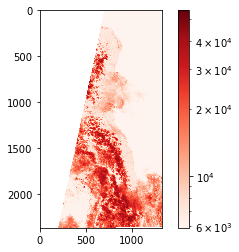

In [33]:
# Use a log scale
plt.imshow(out_image[0], cmap='Reds', norm=LogNorm())
plt.colorbar()

In [35]:
# Excercise. Load and visualize the highest-resolution 15m pancromatic band instead of the red band